<a href="https://colab.research.google.com/github/MicroPyscho/Credit-Card-Fraud-Prediction-using-GAN/blob/main/Copy_of_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gan
!pip install --upgrade matplotlib seaborn
!pip install ssgan
#!pip install tabgan

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import plot_model
#from ssgan.ssgan import SemiSupervisedGAN
import pandas as pd
from datetime import datetime

ERROR: Could not find a version that satisfies the requirement ssgan (from versions: none)
ERROR: No matching distribution found for ssgan


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/df_train.csv'
df_train_contd = pd.read_csv(file_path)

In [ ]:
df_train_contd.head()

,Unnamed: 0,cc_num,category,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,tx_time,age
0,0,2703186189652095,misc_net,4.97,F,28654,36.0788,-81.1781,3495,36.011293,-82.048315,0,00:00:18,36
1,1,630423337322,grocery_pos,107.23,F,99160,48.8878,-118.2105,149,49.159047,-118.186462,0,00:00:44,45
2,2,38859492057661,entertainment,220.11,M,83252,42.1808,-112.2620,4154,43.150704,-112.154481,0,00:00:51,62
3,3,3534093764340240,gas_transport,45.00,M,59632,46.2306,-112.1138,1939,47.034331,-112.561071,0,00:01:16,57
4,4,375534208663984,misc_pos,41.96,M,24433,38.4207,-79.4629,99,38.674999,-78.632459,0,00:03:06,37


In [ ]:
!pip install pyarrow

import pandas as pd

df_train_contd.reset_index(drop=True, inplace=True)

minor_class = df_train_contd[df_train_contd['is_fraud'] == 1]
major_class = df_train_contd[df_train_contd['is_fraud'] == 0]

num_minority = minor_class.shape[0]
num_majority = major_class.shape[0]

minor_sample_prop = 0.7

num_minor_samples = min(int(50000 * minor_sample_prop), num_minority)
num_major_samples = 50000 - num_minor_samples

# Sample from each class separately
minor_samp = minor_class.sample(n=num_minor_samples, random_state=42, replace=num_minor_samples > num_minority)
major_samp = major_class.sample(n=num_major_samples, random_state=42, replace=num_major_samples > num_majority)

# Concatenate the samples
df_train_contd_eg = pd.concat([minor_samp, major_samp], ignore_index=True)

print("Sampled dataset info:")
print(df_train_contd_eg.info())


Sampled dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50000 non-null  int64  
 1   category    50000 non-null  object 
 2   amt         50000 non-null  float64
 3   gender      50000 non-null  object 
 4   zip         50000 non-null  int64  
 5   lat         50000 non-null  float64
 6   long        50000 non-null  float64
 7   city_pop    50000 non-null  int64  
 8   merch_lat   50000 non-null  float64
 9   merch_long  50000 non-null  float64
 10  is_fraud    50000 non-null  int64  
 11  age         50000 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 4.6+ MB
None


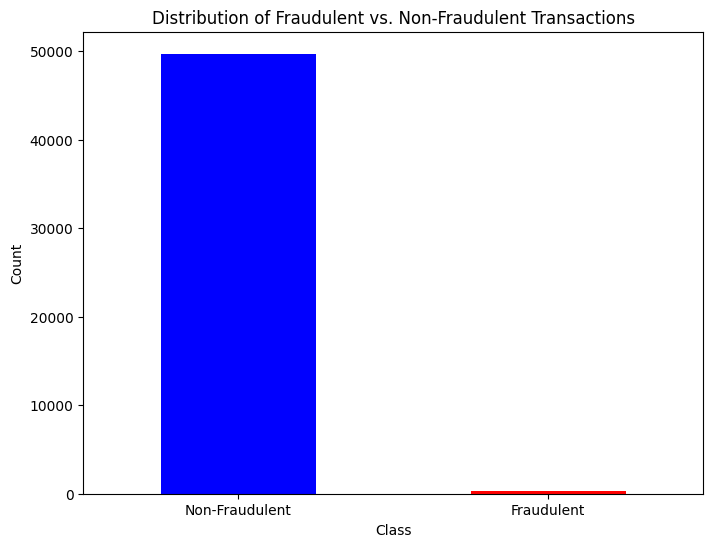

In [ ]:
plt.figure(figsize=(8, 6))
df_train_contd_eg['is_fraud'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'], rotation=0)
plt.show()

In [ ]:
df_train_contd_eg.drop(columns=["tx_time", "cc_num"], inplace=True)
df_train_contd_eg.head()

,Unnamed: 0,category,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,age
0,1045211,misc_pos,194.51,M,15686,40.6153,-79.4545,972,40.420453,-78.865012,0,26
1,547406,health_fitness,52.32,F,97476,42.8250,-124.4409,217,42.758860,-123.636337,0,95
2,110142,shopping_pos,6.53,F,15449,39.9636,-79.7853,184,40.475159,-78.898190,0,78
3,1285953,home,7.33,M,14425,42.9580,-77.3083,10717,43.767506,-76.542384,0,71
4,271705,gas_transport,64.29,F,82221,41.6423,-104.1974,635,41.040392,-104.092324,0,50


In [ ]:
#check for missing values first
missing_values = df_train_contd_eg.isna().sum()

df_train_contd = df_train_contd_eg.reset_index(drop=True, inplace=True)
print("missing values per column:")
print (missing_values)

missing values per column:
Unnamed: 0    0
category      0
amt           0
gender        0
zip           0
lat           0
long          0
city_pop      0
merch_lat     0
merch_long    0
is_fraud      0
age           0
dtype: int64


In [ ]:
import pandas as pd

chunksize = 10000
chunks = []
for chunk in pd.read_csv('/content/drive/MyDrive/df_train.csv', chunksize=chunksize):
  chunks.append(chunk)

  df_train_contd = pd.concat(chunks, ignore_index=True)
print(df_train_contd.columns)

Index(['Unnamed: 0', 'cc_num', 'category', 'amt', 'gender', 'zip', 'lat',
       'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud', 'tx_time',
       'age'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


cat_features = ["category", "gender"]
cat_transformer = OneHotEncoder()

num_features = ["amt", "zip", "lat", "long", "city_pop", "merch_lat", "merch_long", "age"]
num_transformer =StandardScaler()

preprocessor =ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features),
        ("num", num_transformer, num_features)
    ]
)

cat_encoded = cat_transformer.fit_transform(df_train_contd[cat_features])

z_encoded = hstack([cat_encoded, df_train_contd[num_features].values])

encoded_cat_feat = cat_transformer.get_feature_names_out(input_features=cat_features)

#encoded_cat_feat = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)
feature_names = list(encoded_cat_feat) + num_features

print("Original Dataframe shape:", df_train_contd.shape)
print("Encoded DataFrame shape:", z_encoded.shape)
print("feature_names length:", len(feature_names))
print("z_encoded shape:", z_encoded.shape[1])
print("First few rows of z_encoded:")

encoded_df = pd.DataFrame(data=z_encoded.toarray(), columns=feature_names)

df_train_encoded = pd.concat([df_train_contd.drop(columns=cat_features + num_features), encoded_df], axis=1)
print("Original Dataframe shape:", df_train_contd.shape)
print("Encoded DataFrame shape:", df_train_encoded.shape)

df_train_encoded.reset_index(drop=True, inplace=True)
df_train_contd = df_train_encoded
df_train_contd.head()

Original Dataframe shape: (1296675, 14)
Encoded DataFrame shape: (1296675, 24)
feature_names length: 24
z_encoded shape: 24
First few rows of z_encoded:
Original Dataframe shape: (1296675, 14)
Encoded DataFrame shape: (1296675, 28)


,Unnamed: 0,cc_num,is_fraud,tx_time,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,...,gender_F,gender_M,amt,zip,lat,long,city_pop,merch_lat,merch_long,age
0,0,2703186189652095,0,00:00:18,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.97,28654.0,36.0788,-81.1781,3495.0,36.011293,-82.048315,36.0
1,1,630423337322,0,00:00:44,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,107.23,99160.0,48.8878,-118.2105,149.0,49.159047,-118.186462,45.0
2,2,38859492057661,0,00:00:51,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,220.11,83252.0,42.1808,-112.2620,4154.0,43.150704,-112.154481,62.0
3,3,3534093764340240,0,00:01:16,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,45.00,59632.0,46.2306,-112.1138,1939.0,47.034331,-112.561071,57.0
4,4,375534208663984,0,00:03:06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,41.96,24433.0,38.4207,-79.4629,99.0,38.674999,-78.632459,37.0


In [ ]:
df_train_contd.drop(columns=["Unnamed: 0"], inplace=True)
print(df_train_contd.columns)
#df_train_contd.head()

Index(['cc_num', 'is_fraud', 'tx_time', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_F', 'gender_M', 'amt', 'zip', 'lat', 'long', 'city_pop',
       'merch_lat', 'merch_long', 'age'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

#Load data into chunks and preprocess in chunks due to size
num_chunks = 10

#Feature importance containers
num_feats = df_train_contd.shape[1]-1
rf_feature_importance = np.zeros(num_feats)
lasso_feature_coefficients = np.zeros(num_feats)

#separate target from class columns
X = df_train_contd.drop(columns=["is_fraud"])
y = df_train_contd["is_fraud"]

scaler = StandardScaler()

for i in range(num_chunks):
  chunk_size = len(df_train_contd)//num_chunks
  start_idx = i * chunk_size
  end_idx = start_idx + chunk_size
  start_idx = start_idx + chunk_size
  chunk_x = X.iloc[start_idx:end_idx]
  chunk_y = y.iloc[start_idx:end_idx]

  if len(chunk_x) > 0:
    x_chunk_scaled = scaler.fit_transform(chunk_x) #Random Forest Feature Importance
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(x_chunk_scaled, chunk_y)
    rf_feature_importance += rf_model.feature_importances_

    lasso_model = Lasso(alpha=0.1, random_state=42)  #Lasso Regression Feature Importance
    lasso_model.fit(x_chunk_scaled, chunk_y)
    lasso_feature_coefficients += lasso_model.coef_




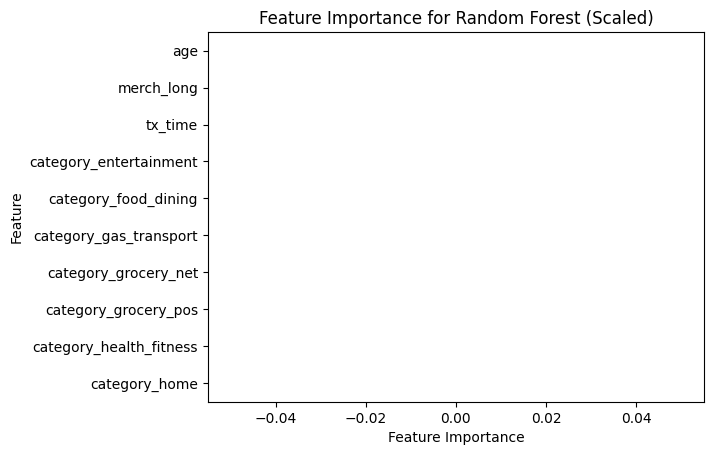

Feature Names: 26
Coefficients: 26
Length of feature importances array: 26
Feature Names: ['cc_num', 'tx_time', 'category_entertainment', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'gender_F', 'gender_M', 'amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age']
Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Length of feature_nms: 26
Length of lasso_feature_coefficients: 26


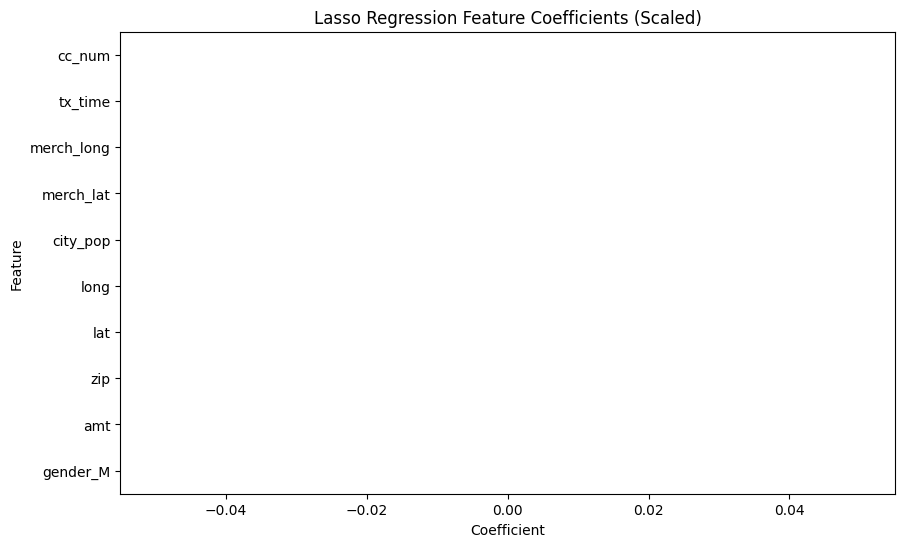

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

def plot_feature_importances(rf_feature_importance, feature_nms, title):
  sorted_idx = rf_feature_importance.argsort()[::-1]
  top_10 = sorted_idx[:10]
  sns.barplot(x=rf_feature_importance[top_10], y=pd.Series(feature_nms)[top_10])
  plt.xlabel("Feature Importance")
  plt.ylabel("Feature")
  plt.title(title)
  plt.show()

def plot_coefficients(lasso_feature_coefficients, feature_nms, title):
    #assert len(feature_nms)==len(lasso_feature_coefficients),"Lengths of feature importance must match"

    print("Length of feature_nms:", len(X.columns.tolist()))
    print("Length of lasso_feature_coefficients:", len(lasso_feature_coefficients))

    coef_df = pd.DataFrame({"Feature": feature_nms,"Coefficient": lasso_feature_coefficients})
    coef_df = coef_df.sort_values(by="Coefficient", ascending=False)
    top_10_co =coef_df.head(10)
    plt.figure(figsize =(10, 6))
    sns.barplot(x="Coefficient", y = "Feature", data=top_10_co)
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.title(title)
    plt.show()

feature_importances_scaled = scaler.fit_transform(rf_feature_importance.reshape(-1, 1))
coefficients_scaled = scaler.fit_transform(lasso_feature_coefficients.reshape(-1, 1))

plot_feature_importances(feature_importances_scaled.flatten(), X.columns.tolist(), "Feature Importance for Random Forest (Scaled)")

feature_nms = X.columns.tolist()

print("Feature Names:", len(feature_nms))
print("Coefficients:", len(lasso_feature_coefficients))

feature_importances_length = len(rf_feature_importance)
print("Length of feature importances array:", feature_importances_length)

print("Feature Names:", feature_nms)
print("Coefficients:", lasso_feature_coefficients)

plot_coefficients(coefficients_scaled.flatten(), X.columns.tolist(), "Lasso Regression Feature Coefficients (Scaled)")


In [ ]:
df_train_contd = df_train_contd_eg
print(df_train_contd.shape)

(50000, 12)


In [ ]:
real_data = df_train_contd.select_dtypes(include={"number"})
print(real_data.shape)
real_data.head()

(50000, 10)


,Unnamed: 0,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,age
0,1045211,194.51,15686,40.6153,-79.4545,972,40.420453,-78.865012,0,26
1,547406,52.32,97476,42.8250,-124.4409,217,42.758860,-123.636337,0,95
2,110142,6.53,15449,39.9636,-79.7853,184,40.475159,-78.898190,0,78
3,1285953,7.33,14425,42.9580,-77.3083,10717,43.767506,-76.542384,0,71
4,271705,64.29,82221,41.6423,-104.1974,635,41.040392,-104.092324,0,50


In [ ]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf

tf.get_logger().setLevel(logging.ERROR)

latent_dim =5000

class Gan():
    def __init__(self, real_data, latent_dim):
        self.real_data = real_data
        self.latent_dim = latent_dim
        self.n_epochs = 10000

    # Generate random noise in a latent space
    def _noise(self):
        noise = np.random.normal(0, 1, (self.real_data.shape[0], self.real_data.shape[1]))
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(5000, activation='relu',input_shape =(self.latent_dim,),
                                         kernel_initializer='he_uniform',
                                         input_dim=self.latent_dim))
        model.add(tf.keras.layers.Dense(1000, activation='relu'))
        model.add(tf.keras.layers.Dense(self.real_data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(5000, activation='relu',
                                         kernel_initializer='he_uniform',
                                         input_dim=self.real_data.shape[1]))
        model.add(tf.keras.layers.Dense(2500, activation='relu'))
        # Sigmoid => Real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        return model

    # Define the combined generator and discriminator model for updating the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # Train the generator and discriminator
    def train(self, generator, discriminator, gan):
        # Manually enumerate epochs
        for epoch in range(self.n_epochs):
            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.real_data.shape[0]), np.zeros(self.real_data.shape[0])])
            X = np.concatenate([self.real_data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.real_data.shape[0]))

            print('>%d, d1=%.3f, d2=%.3f' %(epoch+1, d_loss, g_loss))
        return generator


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

real_data = pd.read_csv("/content/drive/MyDrive/df_train.csv")

# Identify minority class samples
minority_samples = real_data[real_data['is_fraud'] == 1]
gen_data = minority_samples.sample(n=25000, replace=True, random_state=42)
# Normalize the minority samples
scaler = MinMaxScaler()
gen_data_norm = scaler.fit_transform(gen_data)

# Define GAN class and instantiate it with minority samples and latent dimension
latent_dim = 5000
gan_instance = Gan(gen_data_norm, latent_dim)

# Train the GAN model
generator = gan_instance._generator()
discriminator = gan_instance._discriminator()
gan = gan_instance._GAN(generator, discriminator)
trained_generator = gan_instance.train(generator, discriminator, gan)

# Generate synthetic data for the minority class using the trained generator
num_synthetic_samples = 25000  # Adjust the number of synthetic samples as needed
synthetic_minority_data = generate_synthetic_data(trained_generator, num_synthetic_samples, latent_dim)

# Convert synthetic data to DataFrame and inverse transform
augmented_data_df = pd.DataFrame(scaler.inverse_transform(synthetic_minority_data), columns=gen_data.columns)

# Now you have synthetic data for the minority class
print(augmented_data_df)



ValueError: could not convert string to float: 'shopping_net'

In [ ]:
real_data.head()

,Feature_1,Feature_2,is_fraud
0,0.746274,0.892207,0
1,0.441968,0.324308,0
2,0.288029,0.203885,0
3,0.524596,0.996163,0
4,0.473467,0.497392,0


In [ ]:
augmented_data_df.reset_index(drop=True, inplace=True)
real_synth = pd.concat([real_data, augmented_data], ignore_index=True)
real_synth.reset_index(drop=True, inplace=True)
print(real_synth)

In [ ]:
real_synth.head()

In [ ]:
# Step 1: Generate Synthetic Data

latent_dim = 5000

def generate_synthetic_data(generator, num_samples, latent_dim):
    noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data

# Step 2: Evaluate the Generated Data
def evaluate_generated_data(real_data, synthetic_data):
    # Compute statistical measures or evaluation metrics
    # For example, you can compute mean, standard deviation, or use a KS-test
    # You can also visualize distributions or compare summary statistics

    # Here's an example of comparing means of real and synthetic data
    real_mean = np.mean(real_data, axis=0)
    synthetic_mean = np.mean(synthetic_data, axis=0)

    print("Mean of Real Data:", real_mean)
    print("Mean of Synthetic Data:", synthetic_mean)


def compare_correlation(real_data, synthetic_data):
    real_df = pd.DataFrame(real_data, columns=[f'Feature_{i}' for i in range(real_data.shape[1])])
    synthetic_df = pd.DataFrame(synthetic_data, columns=[f'Feature_{i}' for i in range(synthetic_data.shape[1])])
    # Compute correlation matrices
    real_corr = real_df.corr()
    synthetic_corr = synthetic_df.corr()

    # Compare correlation matrices
    corr_diff = synthetic_corr - real_corr

    print("Difference in Correlation Matrices:")
    print(corr_diff)

# Assuming real_data and synthetic_data are pandas DataFrames
correlation_diff = compare_correlation(real_data, synthetic_data)
print("Difference in Correlation Matrices:")
print(correlation_diff)
# Generate synthetic data using the trained generator
num_synthetic_samples = 1000  # Define the number of synthetic samples to generate
latent_dim =64

gan_instance =Gan(real_data, latent_dim)
generator =gan_instance._generator()
synthetic_data = generate_synthetic_data(generator, num_synthetic_samples, latent_dim)

# Evaluate the generated data
evaluate_generated_data(real_data, synthetic_data)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_synthetic_data(generator, num_samples, latent_dim):
    noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data

def evaluate_generated_data(real_data, synthetic_data):
    real_mean = np.mean(real_data, axis=0)
    synthetic_mean = np.mean(synthetic_data, axis=0)
    real_std = np.std(real_data, axis=0)
    synthetic_std = np.std(synthetic_data, axis=0)
    real_min = np.min(real_data, axis=0)
    synthetic_min = np.min(synthetic_data, axis=0)
    real_max = np.max(real_data, axis=0)
    synthetic_max = np.max(synthetic_data, axis=0)

    summary_df = pd.DataFrame({
        'Statistic': ['Mean', 'Standard Deviation', 'Min', 'Max'],
        'Real Data': [real_mean, real_std, real_min, real_max],
        'Synthetic Data': [synthetic_mean, synthetic_std, synthetic_min, synthetic_max]
    })

    print("Summary Statistics:")
    print(summary_df)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    index = np.arange(real_data.shape[1])
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, real_mean, bar_width, alpha=opacity, color='b', label='Real Data')
    rects2 = plt.bar(index + bar_width, synthetic_mean, bar_width, alpha=opacity, color='g', label='Synthetic Data')

    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.title('Mean Comparison')
    plt.xticks(index + bar_width / 2, [f'Feature_{i}' for i in range(real_data.shape[1])])
    plt.legend()

    plt.tight_layout()
    plt.show()

def compare_correlation(real_data, synthetic_data):
    real_df = pd.DataFrame(real_data, columns=[f'Feature_{i}' for i in range(real_data.shape[1])])
    synthetic_df = pd.DataFrame(synthetic_data, columns=[f'Feature_{i}' for i in range(synthetic_data.shape[1])])
    real_corr = real_df.corr()
    synthetic_corr = synthetic_df.corr()
    corr_diff = synthetic_corr - real_corr

    print("Difference in Correlation Matrices:")
    print(corr_diff)

latent_dim = 64
num_synthetic_samples = 1000

# Generate synthetic data using the trained generator
gan_instance = Gan(real_data, latent_dim)
generator = gan_instance._generator()
synthetic_data = generate_synthetic_data(generator, num_synthetic_samples, latent_dim)

# Evaluate the generated data
evaluate_generated_data(real_data, synthetic_data)

# Compare correlation matrices
compare_correlation(real_data, synthetic_data)


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.keras import balanced_batch_generator
from ssgan import SSGAN # Assuming you have an SSGAN implementation

# 1. Balancing using SSGAN
def balance_with_ssgan(real_data, latent_dim, num_epochs):
    # Assuming real_data is a pandas DataFrame with 'is_fraud' column indicating fraud or not fraud

    # Separate fraud and not fraud samples
    fraud_data = real_data[real_data['is_fraud'] == 1]
    not_fraud_data = real_data[real_data['is_fraud'] == 0]

    # Train SSGAN model
    ssgan = SSGAN(real_data.shape[1], latent_dim)
    ssgan.train(real_data.values, num_epochs=num_epochs)

    # Generate synthetic samples for fraud class
    num_synthetic_samples = len(fraud_data)
    synthetic_fraud_data = ssgan.generate_samples(num_synthetic_samples)

    # Combine synthetic fraud data with original not fraud data
    balanced_data = pd.concat([not_fraud_data, pd.DataFrame(synthetic_fraud_data, columns=real_data.columns)], axis=0)

    return balanced_data

# 2. Balancing using SMOTE
def balance_with_smote(real_data):
    # Separate features and target
    X = real_data.drop('is_fraud', axis=1)
    y = real_data['is_fraud']

    # Apply SMOTE
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Combine resampled data
    balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='is_fraud')], axis=1)

    return balanced_data

# Usage
balanced_data_ssgan = balance_with_ssgan(real_data, latent_dim=64, num_epochs=200)
balanced_data_smote = balance_with_smote(real_data)


In [ ]:
fraud_counts = real_data['is_fraud'].value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title('Distribution of Fraud vs Not Fraud')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()